In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import thinkstats2
from statsmodels.stats.power import TTestPower

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

# Covid Death Rates in Murica

Use this data to attempt the analysis below. The section headers below are how I organized it, not a strict requirement. 

In [36]:
df = pd.read_csv("data/covid_deaths.csv")
df.describe()

,unvaccinated,fully_vaccinated,one_booster,two_boosters
count,69.000000,69.000000,69.000000,69.000000
mean,6.903453,1.318059,1.485939,0.558958
std,6.116893,1.148704,1.361103,0.480809
min,0.377413,0.044441,0.040376,0.000000
25%,1.357448,0.297390,0.313206,0.164549
50%,5.367513,1.025216,1.099473,0.488927
75%,10.284717,1.966681,2.359086,0.869313
max,21.037893,4.136138,4.775496,1.905894


<AxesSubplot:xlabel='Day', ylabel='unvaccinated'>

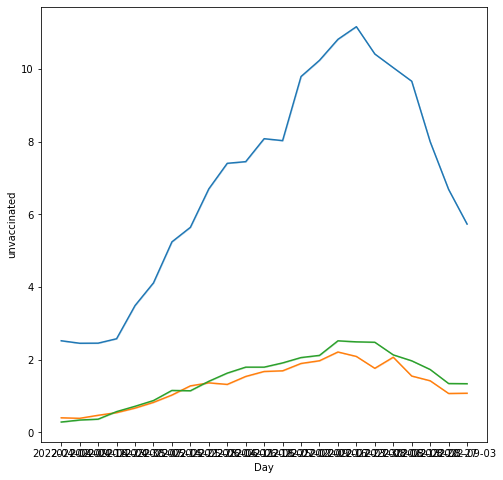

In [3]:
sns.lineplot(data=df, x="Day", y="unvaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="fully_vaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="one_booster", ci=0)

## Is there a significant difference in death rates between Fully Vaccinated people and Unvaccinated people?

#### Create Datasets

In [27]:
dfVaxx = df['fully_vaccinated']
dfUnVaxx = df['unvaccinated']

#### Explore Datasets

<AxesSubplot:xlabel='Day', ylabel='unvaccinated'>

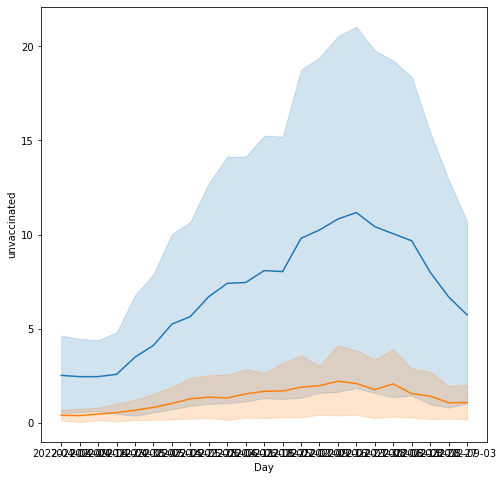

In [21]:
#sns.lineplot(data=dfUnVaxx, x='Day', y='unvaccinated')
#sns.lineplot(data=dfVaxx, x='Day', y='fully_vaccinated')

### Hypothesis Test

First I'll try a regular t-test, then I'll do the non-parametric version, the Mann-Whitney. 

In [28]:
# t-test
vaxStats, vaxP = ss.ttest_ind(dfUnVaxx,dfVaxx)
print(vaxP)

9.50701441183468e-12


In [29]:
# mw
vaxMWStats, vaxMWP = ss.mannwhitneyu(dfUnVaxx,dfVaxx)
print(vaxMWP)


6.299258240567537e-11


### Calculate Power

In [30]:
# Calculate inputs
alpha = 0.05
ces = thinkstats2.CohenEffectSize(dfVaxx,dfUnVaxx)
nobs = dfVaxx.count()+dfUnVaxx.count()

In [31]:
# calculate power
powerTest = TTestPower()
vaxxPower = powerTest.power(alpha=alpha, effect_size=ces, nobs=nobs)
print(vaxxPower)

1.0


### Result

Looks like a statistically significant difference, by every metric. 

## Is There a Significant Difference in Death Rates Between Fully Vaccinated and Boosted Populations*

*The boosted population has two groups - those with one booster and those with two. The one booster group is larger than the two booster group - there are more people with only one booster than there are with two. Use the below ratio to generate a weighted average rate. I.e. if the ratio is .2, that means that 20% of the total boosted population has two doses and 80% have one dose. 

You'll have to calculate this weighted death rate, it should (probably - there's lots of potential ways you could do it) be a simple calculation that spits the result into a new column. 

In [32]:
two_dose_ratio = .2
dfOne = df['one_booster']
dfTwo = df["two_boosters"]

In [37]:
df["boosted"] = (dfOne*0.8)+(dfTwo*0.2)
df['boosted'].head()
dfBoost = df['boosted']

#### Explore

<AxesSubplot:xlabel='Day', ylabel='boosted'>

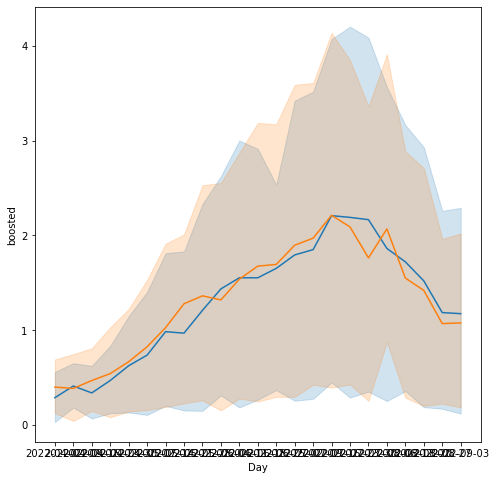

In [35]:
sns.lineplot(data=df, x='Day',y='boosted')
sns.lineplot(data=df, x='Day',y='fully_vaccinated')

#### Test

In [38]:
# t-test
vaxStats, vaxP = ss.ttest_ind(dfBoost,dfVaxx)
print(vaxP)
# mw
vaxMWStats, vaxMWP = ss.mannwhitneyu(dfBoost,dfVaxx)
print(vaxMWP)

0.929695361047642
0.8016297416888358


#### Power

In [39]:
# Calculate inputs
alpha = 0.05
ces = thinkstats2.CohenEffectSize(dfVaxx,dfBoost)
nobs = dfVaxx.count()+dfBoost.count()
# calculate power
boostPower = powerTest.power(effect_size=ces, alpha=alpha, nobs=nobs)
print(boostPower)

0.05353763977604623


#### How Large of a Sample is Needed for a Power of .8?

In [40]:
sample008 = powerTest.solve_power(ces, power=.8, nobs=None, alpha=alpha)
print(sample008)

34659.83744287985


#### More Sophisticated Rates

We can improve the approximation of the number of people with two boosters vs one booster. For this part, try to consider the following, and put this into your data:
<ul>
<li> There is a starting rate of two booster people (similar to above - the proportion of boosted people with 2 boosters). Try this being <b>.1</b>
<li> There is a final rate of two booster people. Try with this being <b>.3</b>
<li> Each day, the ratio of people with boosters who have two increases a set amount, starting with the first value (.1) on day 1, and the last (.3) on the last day. 
</ul>

<b>Note:</b> This is more of a challenge of manipulating the data than of the hypothesis testing. Once the datasets are established, the process is the same as above. The function "np.arrange" may be useful here, but there's probably lots of ways to do it. 

In [44]:
# Plot Ratios
start = .1
cap = .3
perDay = (0.2/69)

In [ ]:
# Add ratio to df
ratio = start
for i in range(df.boosted.count()):
    df['boosted'].iloc[i] = (df['one_booster']*(1-ratio))+(df['two_boosters']*ratio)
    ratio += perDay


In [46]:
# Generate Weighted Boosted Rate
dfBoost = df['boosted']

### Do Test

In [47]:
# t-test
vaxStats, vaxP = ss.ttest_ind(dfBoost,dfVaxx)
print(vaxP)
# mw
vaxMWStats, vaxMWP = ss.mannwhitneyu(dfBoost,dfVaxx)
print(vaxMWP)

0.929695361047642
0.8016297416888358


#### Power

In [48]:
# Calculate inputs
alpha = 0.05
ces = thinkstats2.CohenEffectSize(dfVaxx,dfBoost)
nobs = dfVaxx.count()+dfBoost.count()
# calculate power
boostPower = powerTest.power(effect_size=ces, alpha=alpha, nobs=nobs)
print(boostPower)

0.05353763977604623


## ANOVA

Is there a significant difference between any of the 3 vaccinated groups? Can you test it? 

In [49]:
#First, test for vars being equal-ish
varStat, varVaxx = ss.levene(df['one_booster'], df['two_boosters'], dfBoost)
varVaxx

4.037261537700496e-09

In [51]:
ss.f_oneway(df['one_booster'], df['two_boosters'], dfBoost)

F_onewayResult(statistic=14.33682331855599, pvalue=1.4930110971486819e-06)